In [14]:
import pandas as pd

tf_miRNA = "miR-9-5p"
dataset_num = 1
file_name = "../data/Mission5_Dataset" + str(dataset_num) + "_presort_ORF.xlsx"
sRegDataFile = "../data/Mission5_Dataset" + str(dataset_num) + ".txt"

df = pd.read_excel(file_name, sheetname="sheet1")

df.head()

,Corr_P_Value,Match with known miRNAs,Motif,Motif_Down,Motif_NotDown,NotMotif_Down,NotMotif_NotDown,P_Value,Relative_Risk
0,0.000157,NaN,TAACAGA,73,1010,384,12063,1.066289e-08,2.067572
1,0.000346,NaN,CAGAATT,113,1910,344,11163,2.347188e-08,1.692404
2,0.001850,NaN,GCTCCAG,162,3158,295,9915,1.254650e-07,1.467445
3,0.002014,NaN,AAAAGGT,89,1424,368,11649,1.365458e-07,1.787883
4,0.002510,7mer-A1: miR-607,TTTGAAA,127,2315,330,10758,1.702058e-07,1.569321


In [22]:
ORF_motifs = df["Motif"]
ORF_motifs = list(ORF_motifs)

In [5]:
import pickle

class RefSeq:
	def __init__(self):
		self.sRefID = ""
		self.sGeneSymbol = ""
		self.sChromID = ""
		self.sStrand = ""
		self.nNumExons = 0
		self.lnExStartPs = []
		self.lnExEndPs = []
		#Mission3
		self.sExSeq = "" #It is a concatenated + strand DNA seq!
		self.sORFSeq = ""
		self.s5UTRSeq = ""
		self.s3UTRSeq = ""
		self.nExSize = 0
		self.n5UTRSize = 0
		self.nORFSize = 0
		self.n3UTRSize = 0
		#Check
		self.nCDSStart = 0
		self.nCDSEnd = 0
		self.sCDSSeq = ""
		self.sORFCheck = ""
		#NMD
		self.bNMD = False

	def parse_refflat_line(self, sReadLine):
		sFlds = sReadLine.strip().split('\t')
		self.sRefID = sFlds[1]
		self.sGeneSymbol = sFlds[0]
		self.sChromID = sFlds[2][3:]
		self.sStrand = sFlds[3]
		self.nNumExons = int(sFlds[8])
		self.lnExStartPs = [int(startP) for startP in sFlds[9].strip(",").split(",")]
		self.lnExEndPs = [int(endP) for endP in sFlds[10].strip(",").split(",")]

		self.nCDSStart = int(sFlds[6])
		self.nCDSEnd = int(sFlds[7])

	def putExSeq(self, sExSeq):
		self.sExSeq = sExSeq
		self.nExSize = len(sExSeq)

	def putCDSSeq(self, sCDSSeq):
		self.sCDSSeq = sCDSSeq

	def putTrueEx(self):
		if self.sStrand == '-':
			print("{}: is a - strand".format(self.sRefID))
			print(self.sExSeq[0:10])
			complNucl = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
			sComplExSeq = ""
			sExSeq = self.sExSeq
			for nucl in sExSeq:
				nucl = complNucl[nucl]
				sComplExSeq = nucl + sComplExSeq
			self.sExSeq = sComplExSeq
			print(self.sExSeq[-10:])

	def putTrueCDS(self):
		if self.sStrand == '-':
			print("{}: is a - strand".format(self.sRefID))
			print(self.sCDSSeq[0:10])
			complNucl = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
			sComplCDSSeq = ""
			sCDSSeq = self.sCDSSeq
			for nucl in sCDSSeq:
				nucl = complNucl[nucl]
				sComplCDSSeq = nucl + sComplCDSSeq
			self.sCDSSeq = sComplCDSSeq
			print(self.sCDSSeq[-10:])

	def parseORF(self):
		#print("{}: finding ORF".format(self.sRefID))
		sExSeq = self.sExSeq
		sCDSSeq = self.sCDSSeq
		sStartC = 'ATG'
		lStopCs = ['TAG', 'TAA', 'TGA']
		
		if sCDSSeq[:3] == sStartC:
			if sCDSSeq[-3:] in lStopCs:
				if len(sCDSSeq)%3 == 0:
					lCodons = [sCDSSeq[i:i+3] for i in range(3, len(sCDSSeq)-3, 3)]
					if all((stopC not in lCodons) for stopC in lStopCs):
						nOffStart = sExSeq.find(sCDSSeq)
						assert(nOffStart >= 0), "Does not have matching CDS"
						nOffEnd = nOffStart + len(sCDSSeq)
						self.s5UTRSeq = sExSeq[:nOffStart]
						self.n5UTRSize = len(self.s5UTRSeq)
						self.sORFSeq = sExSeq[nOffStart:nOffEnd]
						self.nORFSize = len(self.sORFSeq)
						self.s3UTRSeq = sExSeq[nOffEnd:]
						self.n3UTRSize = len(self.s3UTRSeq)
						#print("{}: legitimate ORF".format(self.sRefID))
						assert(self.sORFSeq[:3] == 'ATG'), "Wrong Start Codon"
						assert(self.sORFSeq[-3:] in lStopCs), "Wrong End Codon"
					else:
						print("{}: internal stop codon".format(self.sRefID))
						self.sORFCheck = "INTERNAL STOP CODON"
				else:
					print("{}: not a multiple of 3".format(self.sRefID))
					self.sORFCheck = "No MULTIPLE OF 3"
			else:
				print("{}: does not end with STOP Codon".format(self.sRefID))
				self.sORFCheck = "NO STOP CODON"
		else:
			print("{}: does not start with ATG".format(self.sRefID))
			self.sORFCheck = "NO START CODON"

	def checkNMD(self):
		nAfterStop = self.nExSize - self.n3UTRSize
		if self.sStrand == "+":
			nLastEx = self.nExSize - (self.lnExEndPs[-1] - self.lnExStartPs[-1])
		else:
			nLastEx = self.nExSize - (self.lnExEndPs[0] - self.lnExStartPs[0])
		self.bNMD = (nLastEx - nAfterStop > 50)

	def getRefID(self):
		return self.sRefID
	def getGeneSymbol(self):
		return self.sGeneSymbol
	def getChromID(self):
		return self.sChromID
	def getStrand(self):
		return self.sStrand
	def getNumExons(self):
		return self.nNumExons
	def getExStartPs(self):
		return self.lnExStartPs
	def getExEndPs(self):
		return self.lnExEndPs
	def getExSeq(self):
		return self.sExSeq
	def getORFSeq(self):
		return self.sORFSeq
	def getExSize(self):
		return self.nExSize
	def get5UTRSize(self):
		return self.n5UTRSize
	def getORFSize(self):
		return self.nORFSize
	def get3UTRSize(self):
		return self.n3UTRSize
	def get5UTRSeq(self):
		return self.s5UTRSeq
	def get3UTRSeq(self):
		return self.s3UTRSeq

	def getCDSStart(self):
		return self.nCDSStart
	def getCDSEnd(self):
		return self.nCDSEnd
	def getCDSSeq(self):
		return self.sCDSSeq
	def getORFCheck(self):
		return self.sORFCheck

	def getNMD(self):
		return self.bNMD
#End Class Definition

pickle_off = open("../data/Mission3.pickle", "rb")
listCRefSeq = pickle.load(pickle_off)
pickle_off.close()

In [15]:
class miRNA:
	def __init__(self):
		self.sSeq = ""
		self.sName = ""

	def parse_info(self, sName, sSeq):
		self.sSeq = sSeq
		self.sName = sName

	def getName(self):
		return self.sName
	def getSeq(self):
		return self.sSeq

#Mission 5 functions
def fill_miRNA(sMiRNAFile):
	hMiFile = open(sMiRNAFile, 'r')
	sMiData = hMiFile.read().split('>')
	hMiFile.close()

	listFilledCMiRNA = []

	for item in sMiData:
		flds = item.strip().split('\n')
		if len(flds) == 2:
			sSpecy = flds[0].split('-')[0]
			if sSpecy == "hsa":
				cMiRNA = miRNA()
				sName = flds[0].strip().split()[-1]
				sSeq = flds[1].strip().upper()
				sRTSeq = reverse_transcript(sSeq)
				cMiRNA.parse_info(sName, sRTSeq)
				listFilledCMiRNA.append(cMiRNA)

	return listFilledCMiRNA

def reverse_transcript(sSeq):
	dictRT = {'A': 'T', 'C': 'G', 'G': 'C', 'U': 'A'}

	sRTSeq = ""
	for letter in sSeq[1:]:
		rtLetter = dictRT[letter]
		sRTSeq = rtLetter + sRTSeq

	return sRTSeq

def gen_dict_miRNA(listCMiRNA):
	dictCMiRNA = {}

	for cMiRNA in listCMiRNA:
		sName = cMiRNA.getName()
		dictCMiRNA[sName] = cMiRNA

	return dictCMiRNA

def parseRegData(sRegDataFile):
	dictRegData = {}
	hRegDataF = open(sRegDataFile, 'r')
	sRegData = hRegDataF.readlines()
	hRegDataF.close()

	for line in sRegData:
		flds = line.split('\t')
		assert(len(flds)==2), "{}: Does not have proper format".format(line)
		sGeneSymbol = flds[0].strip().upper()
		fReg = float(flds[1].strip())
		dictRegData[sGeneSymbol] = fReg
	#End for
	return dictRegData

sMiRNAFile = "../data/mature.fa"
listCMiRNA = fill_miRNA(sMiRNAFile)
dictCMiRNA = gen_dict_miRNA(listCMiRNA)
dictRegData = parseRegData(sRegDataFile)
dictRegData_Down = {k: v for k, v in dictRegData.items() if v < -0.5}
dictRegData_Not_Down = {k: v for k, v in dictRegData.items() if v >= -0.5}
listCRefSeq_Down = [cRefSeq for cRefSeq in listCRefSeq if cRefSeq.getGeneSymbol().upper() in dictRegData_Down]
listCRefSeq_Not_Down = [cRefSeq for cRefSeq in listCRefSeq if cRefSeq.getGeneSymbol().upper() in dictRegData_Not_Down]
#listCMotif = main_4(sRegDataFile, listCRefSeq, sRegion)
#cMotif = [cMotif for cMotif in listCMotif if cMotif.getMotif() == sMotif][0]
c_tf_miRNA = dictCMiRNA[tf_miRNA]

tf_motif = c_tf_miRNA.getSeq()[-7:]

tf_motifs = [tf_motif, tf_motif[1:] + "A"]

In [16]:
print("TF Motifs: {}".format(tf_motifs))

TF Motifs: ['ACCAAAG', 'CCAAAGA']


In [17]:
def check_correlation(listMotifs, sMotif_ORF, listCRefSeq):
	nORFcnt = 0
	n3UTRcnt = 0
	for cRefSeq in listCRefSeq:
		sORFSeq = cRefSeq.getORFSeq()
		if sMotif_ORF in sORFSeq:
			nORFcnt += 1
			s3UTRSeq = cRefSeq.get3UTRSeq()
			if any([motif in s3UTRSeq for motif in listMotifs]):
				n3UTRcnt += 1
	fCorr = float(n3UTRcnt) / nORFcnt

	return fCorr

def check_correlation_absence(listMotifs, sMotif_ORF, listCRefSeq):
	nORFcnt = 0
	n3UTRcnt = 0
	for cRefSeq in listCRefSeq:
		sORFSeq = cRefSeq.getORFSeq()
		if sMotif_ORF not in sORFSeq:
			nORFcnt += 1
			s3UTRSeq = cRefSeq.get3UTRSeq()
			if all([motif not in s3UTRSeq for motif in listMotifs]):
				n3UTRcnt += 1
	fCorr = float(n3UTRcnt) / nORFcnt

	return fCorr

14747
Progress: 0 / 14747
Progress: 1 / 14747
Progress: 2 / 14747
Progress: 3 / 14747
Progress: 4 / 14747
Progress: 5 / 14747
Progress: 6 / 14747
Progress: 7 / 14747
Progress: 8 / 14747
Progress: 9 / 14747
Progress: 10 / 14747
Progress: 11 / 14747
Progress: 12 / 14747
Progress: 13 / 14747
Progress: 14 / 14747
Progress: 15 / 14747
Progress: 16 / 14747
Progress: 17 / 14747
Progress: 18 / 14747
Progress: 19 / 14747
Progress: 20 / 14747
Progress: 21 / 14747
Progress: 22 / 14747
Progress: 23 / 14747
Progress: 24 / 14747
Progress: 25 / 14747
Progress: 26 / 14747
Progress: 27 / 14747
Progress: 28 / 14747
Progress: 29 / 14747
Progress: 30 / 14747
Progress: 31 / 14747
Progress: 32 / 14747
Progress: 33 / 14747
Progress: 34 / 14747
Progress: 35 / 14747
Progress: 36 / 14747
Progress: 37 / 14747
Progress: 38 / 14747
Progress: 39 / 14747
Progress: 40 / 14747
Progress: 41 / 14747
Progress: 42 / 14747
Progress: 43 / 14747
Progress: 44 / 14747
Progress: 45 / 14747
Progress: 46 / 14747
Progress: 47 / 14

Progress: 378 / 14747
Progress: 379 / 14747
Progress: 380 / 14747
Progress: 381 / 14747
Progress: 382 / 14747
Progress: 383 / 14747
Progress: 384 / 14747
Progress: 385 / 14747
Progress: 386 / 14747
Progress: 387 / 14747
Progress: 388 / 14747
Progress: 389 / 14747
Progress: 390 / 14747
Progress: 391 / 14747
Progress: 392 / 14747
Progress: 393 / 14747
Progress: 394 / 14747
Progress: 395 / 14747
Progress: 396 / 14747
Progress: 397 / 14747
Progress: 398 / 14747
Progress: 399 / 14747
Progress: 400 / 14747
Progress: 401 / 14747
Progress: 402 / 14747
Progress: 403 / 14747
Progress: 404 / 14747
Progress: 405 / 14747
Progress: 406 / 14747
Progress: 407 / 14747
Progress: 408 / 14747
Progress: 409 / 14747
Progress: 410 / 14747
Progress: 411 / 14747
Progress: 412 / 14747
Progress: 413 / 14747
Progress: 414 / 14747
Progress: 415 / 14747
Progress: 416 / 14747
Progress: 417 / 14747
Progress: 418 / 14747
Progress: 419 / 14747
Progress: 420 / 14747
Progress: 421 / 14747
Progress: 422 / 14747
Progress: 

Progress: 753 / 14747
Progress: 754 / 14747
Progress: 755 / 14747
Progress: 756 / 14747
Progress: 757 / 14747
Progress: 758 / 14747
Progress: 759 / 14747
Progress: 760 / 14747
Progress: 761 / 14747
Progress: 762 / 14747
Progress: 763 / 14747
Progress: 764 / 14747
Progress: 765 / 14747
Progress: 766 / 14747
Progress: 767 / 14747
Progress: 768 / 14747
Progress: 769 / 14747
Progress: 770 / 14747
Progress: 771 / 14747
Progress: 772 / 14747
Progress: 773 / 14747
Progress: 774 / 14747
Progress: 775 / 14747
Progress: 776 / 14747
Progress: 777 / 14747
Progress: 778 / 14747
Progress: 779 / 14747
Progress: 780 / 14747
Progress: 781 / 14747
Progress: 782 / 14747
Progress: 783 / 14747
Progress: 784 / 14747
Progress: 785 / 14747
Progress: 786 / 14747
Progress: 787 / 14747
Progress: 788 / 14747
Progress: 789 / 14747
Progress: 790 / 14747
Progress: 791 / 14747
Progress: 792 / 14747
Progress: 793 / 14747
Progress: 794 / 14747
Progress: 795 / 14747
Progress: 796 / 14747
Progress: 797 / 14747
Progress: 

Progress: 1120 / 14747
Progress: 1121 / 14747
Progress: 1122 / 14747
Progress: 1123 / 14747
Progress: 1124 / 14747
Progress: 1125 / 14747
Progress: 1126 / 14747
Progress: 1127 / 14747
Progress: 1128 / 14747
Progress: 1129 / 14747
Progress: 1130 / 14747
Progress: 1131 / 14747
Progress: 1132 / 14747
Progress: 1133 / 14747
Progress: 1134 / 14747
Progress: 1135 / 14747
Progress: 1136 / 14747
Progress: 1137 / 14747
Progress: 1138 / 14747
Progress: 1139 / 14747
Progress: 1140 / 14747
Progress: 1141 / 14747
Progress: 1142 / 14747
Progress: 1143 / 14747
Progress: 1144 / 14747
Progress: 1145 / 14747
Progress: 1146 / 14747
Progress: 1147 / 14747
Progress: 1148 / 14747
Progress: 1149 / 14747
Progress: 1150 / 14747
Progress: 1151 / 14747
Progress: 1152 / 14747
Progress: 1153 / 14747
Progress: 1154 / 14747
Progress: 1155 / 14747
Progress: 1156 / 14747
Progress: 1157 / 14747
Progress: 1158 / 14747
Progress: 1159 / 14747
Progress: 1160 / 14747
Progress: 1161 / 14747
Progress: 1162 / 14747
Progress: 1

Progress: 1477 / 14747
Progress: 1478 / 14747
Progress: 1479 / 14747
Progress: 1480 / 14747
Progress: 1481 / 14747
Progress: 1482 / 14747
Progress: 1483 / 14747
Progress: 1484 / 14747
Progress: 1485 / 14747
Progress: 1486 / 14747
Progress: 1487 / 14747
Progress: 1488 / 14747
Progress: 1489 / 14747
Progress: 1490 / 14747
Progress: 1491 / 14747
Progress: 1492 / 14747
Progress: 1493 / 14747
Progress: 1494 / 14747
Progress: 1495 / 14747
Progress: 1496 / 14747
Progress: 1497 / 14747
Progress: 1498 / 14747
Progress: 1499 / 14747
Progress: 1500 / 14747
Progress: 1501 / 14747
Progress: 1502 / 14747
Progress: 1503 / 14747
Progress: 1504 / 14747
Progress: 1505 / 14747
Progress: 1506 / 14747
Progress: 1507 / 14747
Progress: 1508 / 14747
Progress: 1509 / 14747
Progress: 1510 / 14747
Progress: 1511 / 14747
Progress: 1512 / 14747
Progress: 1513 / 14747
Progress: 1514 / 14747
Progress: 1515 / 14747
Progress: 1516 / 14747
Progress: 1517 / 14747
Progress: 1518 / 14747
Progress: 1519 / 14747
Progress: 1

Progress: 1835 / 14747
Progress: 1836 / 14747
Progress: 1837 / 14747
Progress: 1838 / 14747
Progress: 1839 / 14747
Progress: 1840 / 14747
Progress: 1841 / 14747
Progress: 1842 / 14747
Progress: 1843 / 14747
Progress: 1844 / 14747
Progress: 1845 / 14747
Progress: 1846 / 14747
Progress: 1847 / 14747
Progress: 1848 / 14747
Progress: 1849 / 14747
Progress: 1850 / 14747
Progress: 1851 / 14747
Progress: 1852 / 14747
Progress: 1853 / 14747
Progress: 1854 / 14747
Progress: 1855 / 14747
Progress: 1856 / 14747
Progress: 1857 / 14747
Progress: 1858 / 14747
Progress: 1859 / 14747
Progress: 1860 / 14747
Progress: 1861 / 14747
Progress: 1862 / 14747
Progress: 1863 / 14747
Progress: 1864 / 14747
Progress: 1865 / 14747
Progress: 1866 / 14747
Progress: 1867 / 14747
Progress: 1868 / 14747
Progress: 1869 / 14747
Progress: 1870 / 14747
Progress: 1871 / 14747
Progress: 1872 / 14747
Progress: 1873 / 14747
Progress: 1874 / 14747
Progress: 1875 / 14747
Progress: 1876 / 14747
Progress: 1877 / 14747
Progress: 1

Progress: 2192 / 14747
Progress: 2193 / 14747
Progress: 2194 / 14747
Progress: 2195 / 14747
Progress: 2196 / 14747
Progress: 2197 / 14747
Progress: 2198 / 14747
Progress: 2199 / 14747
Progress: 2200 / 14747
Progress: 2201 / 14747
Progress: 2202 / 14747
Progress: 2203 / 14747
Progress: 2204 / 14747
Progress: 2205 / 14747
Progress: 2206 / 14747
Progress: 2207 / 14747
Progress: 2208 / 14747
Progress: 2209 / 14747
Progress: 2210 / 14747
Progress: 2211 / 14747
Progress: 2212 / 14747
Progress: 2213 / 14747
Progress: 2214 / 14747
Progress: 2215 / 14747
Progress: 2216 / 14747
Progress: 2217 / 14747
Progress: 2218 / 14747
Progress: 2219 / 14747
Progress: 2220 / 14747
Progress: 2221 / 14747
Progress: 2222 / 14747
Progress: 2223 / 14747
Progress: 2224 / 14747
Progress: 2225 / 14747
Progress: 2226 / 14747
Progress: 2227 / 14747
Progress: 2228 / 14747
Progress: 2229 / 14747
Progress: 2230 / 14747
Progress: 2231 / 14747
Progress: 2232 / 14747
Progress: 2233 / 14747
Progress: 2234 / 14747
Progress: 2

Progress: 2549 / 14747
Progress: 2550 / 14747
Progress: 2551 / 14747
Progress: 2552 / 14747
Progress: 2553 / 14747
Progress: 2554 / 14747
Progress: 2555 / 14747
Progress: 2556 / 14747
Progress: 2557 / 14747
Progress: 2558 / 14747
Progress: 2559 / 14747
Progress: 2560 / 14747
Progress: 2561 / 14747
Progress: 2562 / 14747
Progress: 2563 / 14747
Progress: 2564 / 14747
Progress: 2565 / 14747
Progress: 2566 / 14747
Progress: 2567 / 14747
Progress: 2568 / 14747
Progress: 2569 / 14747
Progress: 2570 / 14747
Progress: 2571 / 14747
Progress: 2572 / 14747
Progress: 2573 / 14747
Progress: 2574 / 14747
Progress: 2575 / 14747
Progress: 2576 / 14747
Progress: 2577 / 14747
Progress: 2578 / 14747
Progress: 2579 / 14747
Progress: 2580 / 14747
Progress: 2581 / 14747
Progress: 2582 / 14747
Progress: 2583 / 14747
Progress: 2584 / 14747
Progress: 2585 / 14747
Progress: 2586 / 14747
Progress: 2587 / 14747
Progress: 2588 / 14747
Progress: 2589 / 14747
Progress: 2590 / 14747
Progress: 2591 / 14747
Progress: 2

Progress: 2906 / 14747
Progress: 2907 / 14747
Progress: 2908 / 14747
Progress: 2909 / 14747
Progress: 2910 / 14747
Progress: 2911 / 14747
Progress: 2912 / 14747
Progress: 2913 / 14747
Progress: 2914 / 14747
Progress: 2915 / 14747
Progress: 2916 / 14747
Progress: 2917 / 14747
Progress: 2918 / 14747
Progress: 2919 / 14747
Progress: 2920 / 14747
Progress: 2921 / 14747
Progress: 2922 / 14747
Progress: 2923 / 14747
Progress: 2924 / 14747
Progress: 2925 / 14747
Progress: 2926 / 14747
Progress: 2927 / 14747
Progress: 2928 / 14747
Progress: 2929 / 14747
Progress: 2930 / 14747
Progress: 2931 / 14747
Progress: 2932 / 14747
Progress: 2933 / 14747
Progress: 2934 / 14747
Progress: 2935 / 14747
Progress: 2936 / 14747
Progress: 2937 / 14747
Progress: 2938 / 14747
Progress: 2939 / 14747
Progress: 2940 / 14747
Progress: 2941 / 14747
Progress: 2942 / 14747
Progress: 2943 / 14747
Progress: 2944 / 14747
Progress: 2945 / 14747
Progress: 2946 / 14747
Progress: 2947 / 14747
Progress: 2948 / 14747
Progress: 2

Progress: 3263 / 14747
Progress: 3264 / 14747
Progress: 3265 / 14747
Progress: 3266 / 14747
Progress: 3267 / 14747
Progress: 3268 / 14747
Progress: 3269 / 14747
Progress: 3270 / 14747
Progress: 3271 / 14747
Progress: 3272 / 14747
Progress: 3273 / 14747
Progress: 3274 / 14747
Progress: 3275 / 14747
Progress: 3276 / 14747
Progress: 3277 / 14747
Progress: 3278 / 14747
Progress: 3279 / 14747
Progress: 3280 / 14747
Progress: 3281 / 14747
Progress: 3282 / 14747
Progress: 3283 / 14747
Progress: 3284 / 14747
Progress: 3285 / 14747
Progress: 3286 / 14747
Progress: 3287 / 14747
Progress: 3288 / 14747
Progress: 3289 / 14747
Progress: 3290 / 14747
Progress: 3291 / 14747
Progress: 3292 / 14747
Progress: 3293 / 14747
Progress: 3294 / 14747
Progress: 3295 / 14747
Progress: 3296 / 14747
Progress: 3297 / 14747
Progress: 3298 / 14747
Progress: 3299 / 14747
Progress: 3300 / 14747
Progress: 3301 / 14747
Progress: 3302 / 14747
Progress: 3303 / 14747
Progress: 3304 / 14747
Progress: 3305 / 14747
Progress: 3

Progress: 3620 / 14747
Progress: 3621 / 14747
Progress: 3622 / 14747
Progress: 3623 / 14747
Progress: 3624 / 14747
Progress: 3625 / 14747
Progress: 3626 / 14747
Progress: 3627 / 14747
Progress: 3628 / 14747
Progress: 3629 / 14747
Progress: 3630 / 14747
Progress: 3631 / 14747
Progress: 3632 / 14747
Progress: 3633 / 14747
Progress: 3634 / 14747
Progress: 3635 / 14747
Progress: 3636 / 14747
Progress: 3637 / 14747
Progress: 3638 / 14747
Progress: 3639 / 14747
Progress: 3640 / 14747
Progress: 3641 / 14747
Progress: 3642 / 14747
Progress: 3643 / 14747
Progress: 3644 / 14747
Progress: 3645 / 14747
Progress: 3646 / 14747
Progress: 3647 / 14747
Progress: 3648 / 14747
Progress: 3649 / 14747
Progress: 3650 / 14747
Progress: 3651 / 14747
Progress: 3652 / 14747
Progress: 3653 / 14747
Progress: 3654 / 14747
Progress: 3655 / 14747
Progress: 3656 / 14747
Progress: 3657 / 14747
Progress: 3658 / 14747
Progress: 3659 / 14747
Progress: 3660 / 14747
Progress: 3661 / 14747
Progress: 3662 / 14747
Progress: 3

Progress: 3978 / 14747
Progress: 3979 / 14747
Progress: 3980 / 14747
Progress: 3981 / 14747
Progress: 3982 / 14747
Progress: 3983 / 14747
Progress: 3984 / 14747
Progress: 3985 / 14747
Progress: 3986 / 14747
Progress: 3987 / 14747
Progress: 3988 / 14747
Progress: 3989 / 14747
Progress: 3990 / 14747
Progress: 3991 / 14747
Progress: 3992 / 14747
Progress: 3993 / 14747
Progress: 3994 / 14747
Progress: 3995 / 14747
Progress: 3996 / 14747
Progress: 3997 / 14747
Progress: 3998 / 14747
Progress: 3999 / 14747
Progress: 4000 / 14747
Progress: 4001 / 14747
Progress: 4002 / 14747
Progress: 4003 / 14747
Progress: 4004 / 14747
Progress: 4005 / 14747
Progress: 4006 / 14747
Progress: 4007 / 14747
Progress: 4008 / 14747
Progress: 4009 / 14747
Progress: 4010 / 14747
Progress: 4011 / 14747
Progress: 4012 / 14747
Progress: 4013 / 14747
Progress: 4014 / 14747
Progress: 4015 / 14747
Progress: 4016 / 14747
Progress: 4017 / 14747
Progress: 4018 / 14747
Progress: 4019 / 14747
Progress: 4020 / 14747
Progress: 4

Progress: 4335 / 14747
Progress: 4336 / 14747
Progress: 4337 / 14747
Progress: 4338 / 14747
Progress: 4339 / 14747
Progress: 4340 / 14747
Progress: 4341 / 14747
Progress: 4342 / 14747
Progress: 4343 / 14747
Progress: 4344 / 14747
Progress: 4345 / 14747
Progress: 4346 / 14747
Progress: 4347 / 14747
Progress: 4348 / 14747
Progress: 4349 / 14747
Progress: 4350 / 14747
Progress: 4351 / 14747
Progress: 4352 / 14747
Progress: 4353 / 14747
Progress: 4354 / 14747
Progress: 4355 / 14747
Progress: 4356 / 14747
Progress: 4357 / 14747
Progress: 4358 / 14747
Progress: 4359 / 14747
Progress: 4360 / 14747
Progress: 4361 / 14747
Progress: 4362 / 14747
Progress: 4363 / 14747
Progress: 4364 / 14747
Progress: 4365 / 14747
Progress: 4366 / 14747
Progress: 4367 / 14747
Progress: 4368 / 14747
Progress: 4369 / 14747
Progress: 4370 / 14747
Progress: 4371 / 14747
Progress: 4372 / 14747
Progress: 4373 / 14747
Progress: 4374 / 14747
Progress: 4375 / 14747
Progress: 4376 / 14747
Progress: 4377 / 14747
Progress: 4

Progress: 4693 / 14747
Progress: 4694 / 14747
Progress: 4695 / 14747
Progress: 4696 / 14747
Progress: 4697 / 14747
Progress: 4698 / 14747
Progress: 4699 / 14747
Progress: 4700 / 14747
Progress: 4701 / 14747
Progress: 4702 / 14747
Progress: 4703 / 14747
Progress: 4704 / 14747
Progress: 4705 / 14747
Progress: 4706 / 14747
Progress: 4707 / 14747
Progress: 4708 / 14747
Progress: 4709 / 14747
Progress: 4710 / 14747
Progress: 4711 / 14747
Progress: 4712 / 14747
Progress: 4713 / 14747
Progress: 4714 / 14747
Progress: 4715 / 14747
Progress: 4716 / 14747
Progress: 4717 / 14747
Progress: 4718 / 14747
Progress: 4719 / 14747
Progress: 4720 / 14747
Progress: 4721 / 14747
Progress: 4722 / 14747
Progress: 4723 / 14747
Progress: 4724 / 14747
Progress: 4725 / 14747
Progress: 4726 / 14747
Progress: 4727 / 14747
Progress: 4728 / 14747
Progress: 4729 / 14747
Progress: 4730 / 14747
Progress: 4731 / 14747
Progress: 4732 / 14747
Progress: 4733 / 14747
Progress: 4734 / 14747
Progress: 4735 / 14747
Progress: 4

Progress: 5052 / 14747
Progress: 5053 / 14747
Progress: 5054 / 14747
Progress: 5055 / 14747
Progress: 5056 / 14747
Progress: 5057 / 14747
Progress: 5058 / 14747
Progress: 5059 / 14747
Progress: 5060 / 14747
Progress: 5061 / 14747
Progress: 5062 / 14747
Progress: 5063 / 14747
Progress: 5064 / 14747
Progress: 5065 / 14747
Progress: 5066 / 14747
Progress: 5067 / 14747
Progress: 5068 / 14747
Progress: 5069 / 14747
Progress: 5070 / 14747
Progress: 5071 / 14747
Progress: 5072 / 14747
Progress: 5073 / 14747
Progress: 5074 / 14747
Progress: 5075 / 14747
Progress: 5076 / 14747
Progress: 5077 / 14747
Progress: 5078 / 14747
Progress: 5079 / 14747
Progress: 5080 / 14747
Progress: 5081 / 14747
Progress: 5082 / 14747
Progress: 5083 / 14747
Progress: 5084 / 14747
Progress: 5085 / 14747
Progress: 5086 / 14747
Progress: 5087 / 14747
Progress: 5088 / 14747
Progress: 5089 / 14747
Progress: 5090 / 14747
Progress: 5091 / 14747
Progress: 5092 / 14747
Progress: 5093 / 14747
Progress: 5094 / 14747
Progress: 5

Progress: 5409 / 14747
Progress: 5410 / 14747
Progress: 5411 / 14747
Progress: 5412 / 14747
Progress: 5413 / 14747
Progress: 5414 / 14747
Progress: 5415 / 14747
Progress: 5416 / 14747
Progress: 5417 / 14747
Progress: 5418 / 14747
Progress: 5419 / 14747
Progress: 5420 / 14747
Progress: 5421 / 14747
Progress: 5422 / 14747
Progress: 5423 / 14747
Progress: 5424 / 14747
Progress: 5425 / 14747
Progress: 5426 / 14747
Progress: 5427 / 14747
Progress: 5428 / 14747
Progress: 5429 / 14747
Progress: 5430 / 14747
Progress: 5431 / 14747
Progress: 5432 / 14747
Progress: 5433 / 14747
Progress: 5434 / 14747
Progress: 5435 / 14747
Progress: 5436 / 14747
Progress: 5437 / 14747
Progress: 5438 / 14747
Progress: 5439 / 14747
Progress: 5440 / 14747
Progress: 5441 / 14747
Progress: 5442 / 14747
Progress: 5443 / 14747
Progress: 5444 / 14747
Progress: 5445 / 14747
Progress: 5446 / 14747
Progress: 5447 / 14747
Progress: 5448 / 14747
Progress: 5449 / 14747
Progress: 5450 / 14747
Progress: 5451 / 14747
Progress: 5

Progress: 5767 / 14747
Progress: 5768 / 14747
Progress: 5769 / 14747
Progress: 5770 / 14747
Progress: 5771 / 14747
Progress: 5772 / 14747
Progress: 5773 / 14747
Progress: 5774 / 14747
Progress: 5775 / 14747
Progress: 5776 / 14747
Progress: 5777 / 14747
Progress: 5778 / 14747
Progress: 5779 / 14747
Progress: 5780 / 14747
Progress: 5781 / 14747
Progress: 5782 / 14747
Progress: 5783 / 14747
Progress: 5784 / 14747
Progress: 5785 / 14747
Progress: 5786 / 14747
Progress: 5787 / 14747
Progress: 5788 / 14747
Progress: 5789 / 14747
Progress: 5790 / 14747
Progress: 5791 / 14747
Progress: 5792 / 14747
Progress: 5793 / 14747
Progress: 5794 / 14747
Progress: 5795 / 14747
Progress: 5796 / 14747
Progress: 5797 / 14747
Progress: 5798 / 14747
Progress: 5799 / 14747
Progress: 5800 / 14747
Progress: 5801 / 14747
Progress: 5802 / 14747
Progress: 5803 / 14747
Progress: 5804 / 14747
Progress: 5805 / 14747
Progress: 5806 / 14747
Progress: 5807 / 14747
Progress: 5808 / 14747
Progress: 5809 / 14747
Progress: 5

Progress: 6125 / 14747
Progress: 6126 / 14747
Progress: 6127 / 14747
Progress: 6128 / 14747
Progress: 6129 / 14747
Progress: 6130 / 14747
Progress: 6131 / 14747
Progress: 6132 / 14747
Progress: 6133 / 14747
Progress: 6134 / 14747
Progress: 6135 / 14747
Progress: 6136 / 14747
Progress: 6137 / 14747
Progress: 6138 / 14747
Progress: 6139 / 14747
Progress: 6140 / 14747
Progress: 6141 / 14747
Progress: 6142 / 14747
Progress: 6143 / 14747
Progress: 6144 / 14747
Progress: 6145 / 14747
Progress: 6146 / 14747
Progress: 6147 / 14747
Progress: 6148 / 14747
Progress: 6149 / 14747
Progress: 6150 / 14747
Progress: 6151 / 14747
Progress: 6152 / 14747
Progress: 6153 / 14747
Progress: 6154 / 14747
Progress: 6155 / 14747
Progress: 6156 / 14747
Progress: 6157 / 14747
Progress: 6158 / 14747
Progress: 6159 / 14747
Progress: 6160 / 14747
Progress: 6161 / 14747
Progress: 6162 / 14747
Progress: 6163 / 14747
Progress: 6164 / 14747
Progress: 6165 / 14747
Progress: 6166 / 14747
Progress: 6167 / 14747
Progress: 6

Progress: 6482 / 14747
Progress: 6483 / 14747
Progress: 6484 / 14747
Progress: 6485 / 14747
Progress: 6486 / 14747
Progress: 6487 / 14747
Progress: 6488 / 14747
Progress: 6489 / 14747
Progress: 6490 / 14747
Progress: 6491 / 14747
Progress: 6492 / 14747
Progress: 6493 / 14747
Progress: 6494 / 14747
Progress: 6495 / 14747
Progress: 6496 / 14747
Progress: 6497 / 14747
Progress: 6498 / 14747
Progress: 6499 / 14747
Progress: 6500 / 14747
Progress: 6501 / 14747
Progress: 6502 / 14747
Progress: 6503 / 14747
Progress: 6504 / 14747
Progress: 6505 / 14747
Progress: 6506 / 14747
Progress: 6507 / 14747
Progress: 6508 / 14747
Progress: 6509 / 14747
Progress: 6510 / 14747
Progress: 6511 / 14747
Progress: 6512 / 14747
Progress: 6513 / 14747
Progress: 6514 / 14747
Progress: 6515 / 14747
Progress: 6516 / 14747
Progress: 6517 / 14747
Progress: 6518 / 14747
Progress: 6519 / 14747
Progress: 6520 / 14747
Progress: 6521 / 14747
Progress: 6522 / 14747
Progress: 6523 / 14747
Progress: 6524 / 14747
Progress: 6

Progress: 6839 / 14747
Progress: 6840 / 14747
Progress: 6841 / 14747
Progress: 6842 / 14747
Progress: 6843 / 14747
Progress: 6844 / 14747
Progress: 6845 / 14747
Progress: 6846 / 14747
Progress: 6847 / 14747
Progress: 6848 / 14747
Progress: 6849 / 14747
Progress: 6850 / 14747
Progress: 6851 / 14747
Progress: 6852 / 14747
Progress: 6853 / 14747
Progress: 6854 / 14747
Progress: 6855 / 14747
Progress: 6856 / 14747
Progress: 6857 / 14747
Progress: 6858 / 14747
Progress: 6859 / 14747
Progress: 6860 / 14747
Progress: 6861 / 14747
Progress: 6862 / 14747
Progress: 6863 / 14747
Progress: 6864 / 14747
Progress: 6865 / 14747
Progress: 6866 / 14747
Progress: 6867 / 14747
Progress: 6868 / 14747
Progress: 6869 / 14747
Progress: 6870 / 14747
Progress: 6871 / 14747
Progress: 6872 / 14747
Progress: 6873 / 14747
Progress: 6874 / 14747
Progress: 6875 / 14747
Progress: 6876 / 14747
Progress: 6877 / 14747
Progress: 6878 / 14747
Progress: 6879 / 14747
Progress: 6880 / 14747
Progress: 6881 / 14747
Progress: 6

Progress: 7197 / 14747
Progress: 7198 / 14747
Progress: 7199 / 14747
Progress: 7200 / 14747
Progress: 7201 / 14747
Progress: 7202 / 14747
Progress: 7203 / 14747
Progress: 7204 / 14747
Progress: 7205 / 14747
Progress: 7206 / 14747
Progress: 7207 / 14747
Progress: 7208 / 14747
Progress: 7209 / 14747
Progress: 7210 / 14747
Progress: 7211 / 14747
Progress: 7212 / 14747
Progress: 7213 / 14747
Progress: 7214 / 14747
Progress: 7215 / 14747
Progress: 7216 / 14747
Progress: 7217 / 14747
Progress: 7218 / 14747
Progress: 7219 / 14747
Progress: 7220 / 14747
Progress: 7221 / 14747
Progress: 7222 / 14747
Progress: 7223 / 14747
Progress: 7224 / 14747
Progress: 7225 / 14747
Progress: 7226 / 14747
Progress: 7227 / 14747
Progress: 7228 / 14747
Progress: 7229 / 14747
Progress: 7230 / 14747
Progress: 7231 / 14747
Progress: 7232 / 14747
Progress: 7233 / 14747
Progress: 7234 / 14747
Progress: 7235 / 14747
Progress: 7236 / 14747
Progress: 7237 / 14747
Progress: 7238 / 14747
Progress: 7239 / 14747
Progress: 7

Progress: 7556 / 14747
Progress: 7557 / 14747
Progress: 7558 / 14747
Progress: 7559 / 14747
Progress: 7560 / 14747
Progress: 7561 / 14747
Progress: 7562 / 14747
Progress: 7563 / 14747
Progress: 7564 / 14747
Progress: 7565 / 14747
Progress: 7566 / 14747
Progress: 7567 / 14747
Progress: 7568 / 14747
Progress: 7569 / 14747
Progress: 7570 / 14747
Progress: 7571 / 14747
Progress: 7572 / 14747
Progress: 7573 / 14747
Progress: 7574 / 14747
Progress: 7575 / 14747
Progress: 7576 / 14747
Progress: 7577 / 14747
Progress: 7578 / 14747
Progress: 7579 / 14747
Progress: 7580 / 14747
Progress: 7581 / 14747
Progress: 7582 / 14747
Progress: 7583 / 14747
Progress: 7584 / 14747
Progress: 7585 / 14747
Progress: 7586 / 14747
Progress: 7587 / 14747
Progress: 7588 / 14747
Progress: 7589 / 14747
Progress: 7590 / 14747
Progress: 7591 / 14747
Progress: 7592 / 14747
Progress: 7593 / 14747
Progress: 7594 / 14747
Progress: 7595 / 14747
Progress: 7596 / 14747
Progress: 7597 / 14747
Progress: 7598 / 14747
Progress: 7

Progress: 7914 / 14747
Progress: 7915 / 14747
Progress: 7916 / 14747
Progress: 7917 / 14747
Progress: 7918 / 14747
Progress: 7919 / 14747
Progress: 7920 / 14747
Progress: 7921 / 14747
Progress: 7922 / 14747
Progress: 7923 / 14747
Progress: 7924 / 14747
Progress: 7925 / 14747
Progress: 7926 / 14747
Progress: 7927 / 14747
Progress: 7928 / 14747
Progress: 7929 / 14747
Progress: 7930 / 14747
Progress: 7931 / 14747
Progress: 7932 / 14747
Progress: 7933 / 14747
Progress: 7934 / 14747
Progress: 7935 / 14747
Progress: 7936 / 14747
Progress: 7937 / 14747
Progress: 7938 / 14747
Progress: 7939 / 14747
Progress: 7940 / 14747
Progress: 7941 / 14747
Progress: 7942 / 14747
Progress: 7943 / 14747
Progress: 7944 / 14747
Progress: 7945 / 14747
Progress: 7946 / 14747
Progress: 7947 / 14747
Progress: 7948 / 14747
Progress: 7949 / 14747
Progress: 7950 / 14747
Progress: 7951 / 14747
Progress: 7952 / 14747
Progress: 7953 / 14747
Progress: 7954 / 14747
Progress: 7955 / 14747
Progress: 7956 / 14747
Progress: 7

Progress: 8271 / 14747
Progress: 8272 / 14747
Progress: 8273 / 14747
Progress: 8274 / 14747
Progress: 8275 / 14747
Progress: 8276 / 14747
Progress: 8277 / 14747
Progress: 8278 / 14747
Progress: 8279 / 14747
Progress: 8280 / 14747
Progress: 8281 / 14747
Progress: 8282 / 14747
Progress: 8283 / 14747
Progress: 8284 / 14747
Progress: 8285 / 14747
Progress: 8286 / 14747
Progress: 8287 / 14747
Progress: 8288 / 14747
Progress: 8289 / 14747
Progress: 8290 / 14747
Progress: 8291 / 14747
Progress: 8292 / 14747
Progress: 8293 / 14747
Progress: 8294 / 14747
Progress: 8295 / 14747
Progress: 8296 / 14747
Progress: 8297 / 14747
Progress: 8298 / 14747
Progress: 8299 / 14747
Progress: 8300 / 14747
Progress: 8301 / 14747
Progress: 8302 / 14747
Progress: 8303 / 14747
Progress: 8304 / 14747
Progress: 8305 / 14747
Progress: 8306 / 14747
Progress: 8307 / 14747
Progress: 8308 / 14747
Progress: 8309 / 14747
Progress: 8310 / 14747
Progress: 8311 / 14747
Progress: 8312 / 14747
Progress: 8313 / 14747
Progress: 8

Progress: 8628 / 14747
Progress: 8629 / 14747
Progress: 8630 / 14747
Progress: 8631 / 14747
Progress: 8632 / 14747
Progress: 8633 / 14747
Progress: 8634 / 14747
Progress: 8635 / 14747
Progress: 8636 / 14747
Progress: 8637 / 14747
Progress: 8638 / 14747
Progress: 8639 / 14747
Progress: 8640 / 14747
Progress: 8641 / 14747
Progress: 8642 / 14747
Progress: 8643 / 14747
Progress: 8644 / 14747
Progress: 8645 / 14747
Progress: 8646 / 14747
Progress: 8647 / 14747
Progress: 8648 / 14747
Progress: 8649 / 14747
Progress: 8650 / 14747
Progress: 8651 / 14747
Progress: 8652 / 14747
Progress: 8653 / 14747
Progress: 8654 / 14747
Progress: 8655 / 14747
Progress: 8656 / 14747
Progress: 8657 / 14747
Progress: 8658 / 14747
Progress: 8659 / 14747
Progress: 8660 / 14747
Progress: 8661 / 14747
Progress: 8662 / 14747
Progress: 8663 / 14747
Progress: 8664 / 14747
Progress: 8665 / 14747
Progress: 8666 / 14747
Progress: 8667 / 14747
Progress: 8668 / 14747
Progress: 8669 / 14747
Progress: 8670 / 14747
Progress: 8

Progress: 8985 / 14747
Progress: 8986 / 14747
Progress: 8987 / 14747
Progress: 8988 / 14747
Progress: 8989 / 14747
Progress: 8990 / 14747
Progress: 8991 / 14747
Progress: 8992 / 14747
Progress: 8993 / 14747
Progress: 8994 / 14747
Progress: 8995 / 14747
Progress: 8996 / 14747
Progress: 8997 / 14747
Progress: 8998 / 14747
Progress: 8999 / 14747
Progress: 9000 / 14747
Progress: 9001 / 14747
Progress: 9002 / 14747
Progress: 9003 / 14747
Progress: 9004 / 14747
Progress: 9005 / 14747
Progress: 9006 / 14747
Progress: 9007 / 14747
Progress: 9008 / 14747
Progress: 9009 / 14747
Progress: 9010 / 14747
Progress: 9011 / 14747
Progress: 9012 / 14747
Progress: 9013 / 14747
Progress: 9014 / 14747
Progress: 9015 / 14747
Progress: 9016 / 14747
Progress: 9017 / 14747
Progress: 9018 / 14747
Progress: 9019 / 14747
Progress: 9020 / 14747
Progress: 9021 / 14747
Progress: 9022 / 14747
Progress: 9023 / 14747
Progress: 9024 / 14747
Progress: 9025 / 14747
Progress: 9026 / 14747
Progress: 9027 / 14747
Progress: 9

Progress: 9343 / 14747
Progress: 9344 / 14747
Progress: 9345 / 14747
Progress: 9346 / 14747
Progress: 9347 / 14747
Progress: 9348 / 14747
Progress: 9349 / 14747
Progress: 9350 / 14747
Progress: 9351 / 14747
Progress: 9352 / 14747
Progress: 9353 / 14747
Progress: 9354 / 14747
Progress: 9355 / 14747
Progress: 9356 / 14747
Progress: 9357 / 14747
Progress: 9358 / 14747
Progress: 9359 / 14747
Progress: 9360 / 14747
Progress: 9361 / 14747
Progress: 9362 / 14747
Progress: 9363 / 14747
Progress: 9364 / 14747
Progress: 9365 / 14747
Progress: 9366 / 14747
Progress: 9367 / 14747
Progress: 9368 / 14747
Progress: 9369 / 14747
Progress: 9370 / 14747
Progress: 9371 / 14747
Progress: 9372 / 14747
Progress: 9373 / 14747
Progress: 9374 / 14747
Progress: 9375 / 14747
Progress: 9376 / 14747
Progress: 9377 / 14747
Progress: 9378 / 14747
Progress: 9379 / 14747
Progress: 9380 / 14747
Progress: 9381 / 14747
Progress: 9382 / 14747
Progress: 9383 / 14747
Progress: 9384 / 14747
Progress: 9385 / 14747
Progress: 9

Progress: 9701 / 14747
Progress: 9702 / 14747
Progress: 9703 / 14747
Progress: 9704 / 14747
Progress: 9705 / 14747
Progress: 9706 / 14747
Progress: 9707 / 14747
Progress: 9708 / 14747
Progress: 9709 / 14747
Progress: 9710 / 14747
Progress: 9711 / 14747
Progress: 9712 / 14747
Progress: 9713 / 14747
Progress: 9714 / 14747
Progress: 9715 / 14747
Progress: 9716 / 14747
Progress: 9717 / 14747
Progress: 9718 / 14747
Progress: 9719 / 14747
Progress: 9720 / 14747
Progress: 9721 / 14747
Progress: 9722 / 14747
Progress: 9723 / 14747
Progress: 9724 / 14747
Progress: 9725 / 14747
Progress: 9726 / 14747
Progress: 9727 / 14747
Progress: 9728 / 14747
Progress: 9729 / 14747
Progress: 9730 / 14747
Progress: 9731 / 14747
Progress: 9732 / 14747
Progress: 9733 / 14747
Progress: 9734 / 14747
Progress: 9735 / 14747
Progress: 9736 / 14747
Progress: 9737 / 14747
Progress: 9738 / 14747
Progress: 9739 / 14747
Progress: 9740 / 14747
Progress: 9741 / 14747
Progress: 9742 / 14747
Progress: 9743 / 14747
Progress: 9

Progress: 10057 / 14747
Progress: 10058 / 14747
Progress: 10059 / 14747
Progress: 10060 / 14747
Progress: 10061 / 14747
Progress: 10062 / 14747
Progress: 10063 / 14747
Progress: 10064 / 14747
Progress: 10065 / 14747
Progress: 10066 / 14747
Progress: 10067 / 14747
Progress: 10068 / 14747
Progress: 10069 / 14747
Progress: 10070 / 14747
Progress: 10071 / 14747
Progress: 10072 / 14747
Progress: 10073 / 14747
Progress: 10074 / 14747
Progress: 10075 / 14747
Progress: 10076 / 14747
Progress: 10077 / 14747
Progress: 10078 / 14747
Progress: 10079 / 14747
Progress: 10080 / 14747
Progress: 10081 / 14747
Progress: 10082 / 14747
Progress: 10083 / 14747
Progress: 10084 / 14747
Progress: 10085 / 14747
Progress: 10086 / 14747
Progress: 10087 / 14747
Progress: 10088 / 14747
Progress: 10089 / 14747
Progress: 10090 / 14747
Progress: 10091 / 14747
Progress: 10092 / 14747
Progress: 10093 / 14747
Progress: 10094 / 14747
Progress: 10095 / 14747
Progress: 10096 / 14747
Progress: 10097 / 14747
Progress: 10098 

Progress: 10399 / 14747
Progress: 10400 / 14747
Progress: 10401 / 14747
Progress: 10402 / 14747
Progress: 10403 / 14747
Progress: 10404 / 14747
Progress: 10405 / 14747
Progress: 10406 / 14747
Progress: 10407 / 14747
Progress: 10408 / 14747
Progress: 10409 / 14747
Progress: 10410 / 14747
Progress: 10411 / 14747
Progress: 10412 / 14747
Progress: 10413 / 14747
Progress: 10414 / 14747
Progress: 10415 / 14747
Progress: 10416 / 14747
Progress: 10417 / 14747
Progress: 10418 / 14747
Progress: 10419 / 14747
Progress: 10420 / 14747
Progress: 10421 / 14747
Progress: 10422 / 14747
Progress: 10423 / 14747
Progress: 10424 / 14747
Progress: 10425 / 14747
Progress: 10426 / 14747
Progress: 10427 / 14747
Progress: 10428 / 14747
Progress: 10429 / 14747
Progress: 10430 / 14747
Progress: 10431 / 14747
Progress: 10432 / 14747
Progress: 10433 / 14747
Progress: 10434 / 14747
Progress: 10435 / 14747
Progress: 10436 / 14747
Progress: 10437 / 14747
Progress: 10438 / 14747
Progress: 10439 / 14747
Progress: 10440 

Progress: 10743 / 14747
Progress: 10744 / 14747
Progress: 10745 / 14747
Progress: 10746 / 14747
Progress: 10747 / 14747
Progress: 10748 / 14747
Progress: 10749 / 14747
Progress: 10750 / 14747
Progress: 10751 / 14747
Progress: 10752 / 14747
Progress: 10753 / 14747
Progress: 10754 / 14747
Progress: 10755 / 14747
Progress: 10756 / 14747
Progress: 10757 / 14747
Progress: 10758 / 14747
Progress: 10759 / 14747
Progress: 10760 / 14747
Progress: 10761 / 14747
Progress: 10762 / 14747
Progress: 10763 / 14747
Progress: 10764 / 14747
Progress: 10765 / 14747
Progress: 10766 / 14747
Progress: 10767 / 14747
Progress: 10768 / 14747
Progress: 10769 / 14747
Progress: 10770 / 14747
Progress: 10771 / 14747
Progress: 10772 / 14747
Progress: 10773 / 14747
Progress: 10774 / 14747
Progress: 10775 / 14747
Progress: 10776 / 14747
Progress: 10777 / 14747
Progress: 10778 / 14747
Progress: 10779 / 14747
Progress: 10780 / 14747
Progress: 10781 / 14747
Progress: 10782 / 14747
Progress: 10783 / 14747
Progress: 10784 

Progress: 11086 / 14747
Progress: 11087 / 14747
Progress: 11088 / 14747
Progress: 11089 / 14747
Progress: 11090 / 14747
Progress: 11091 / 14747
Progress: 11092 / 14747
Progress: 11093 / 14747
Progress: 11094 / 14747
Progress: 11095 / 14747
Progress: 11096 / 14747
Progress: 11097 / 14747
Progress: 11098 / 14747
Progress: 11099 / 14747
Progress: 11100 / 14747
Progress: 11101 / 14747
Progress: 11102 / 14747
Progress: 11103 / 14747
Progress: 11104 / 14747
Progress: 11105 / 14747
Progress: 11106 / 14747
Progress: 11107 / 14747
Progress: 11108 / 14747
Progress: 11109 / 14747
Progress: 11110 / 14747
Progress: 11111 / 14747
Progress: 11112 / 14747
Progress: 11113 / 14747
Progress: 11114 / 14747
Progress: 11115 / 14747
Progress: 11116 / 14747
Progress: 11117 / 14747
Progress: 11118 / 14747
Progress: 11119 / 14747
Progress: 11120 / 14747
Progress: 11121 / 14747
Progress: 11122 / 14747
Progress: 11123 / 14747
Progress: 11124 / 14747
Progress: 11125 / 14747
Progress: 11126 / 14747
Progress: 11127 

Progress: 11429 / 14747
Progress: 11430 / 14747
Progress: 11431 / 14747
Progress: 11432 / 14747
Progress: 11433 / 14747
Progress: 11434 / 14747
Progress: 11435 / 14747
Progress: 11436 / 14747
Progress: 11437 / 14747
Progress: 11438 / 14747
Progress: 11439 / 14747
Progress: 11440 / 14747
Progress: 11441 / 14747
Progress: 11442 / 14747
Progress: 11443 / 14747
Progress: 11444 / 14747
Progress: 11445 / 14747
Progress: 11446 / 14747
Progress: 11447 / 14747
Progress: 11448 / 14747
Progress: 11449 / 14747
Progress: 11450 / 14747
Progress: 11451 / 14747
Progress: 11452 / 14747
Progress: 11453 / 14747
Progress: 11454 / 14747
Progress: 11455 / 14747
Progress: 11456 / 14747
Progress: 11457 / 14747
Progress: 11458 / 14747
Progress: 11459 / 14747
Progress: 11460 / 14747
Progress: 11461 / 14747
Progress: 11462 / 14747
Progress: 11463 / 14747
Progress: 11464 / 14747
Progress: 11465 / 14747
Progress: 11466 / 14747
Progress: 11467 / 14747
Progress: 11468 / 14747
Progress: 11469 / 14747
Progress: 11470 

Progress: 11771 / 14747
Progress: 11772 / 14747
Progress: 11773 / 14747
Progress: 11774 / 14747
Progress: 11775 / 14747
Progress: 11776 / 14747
Progress: 11777 / 14747
Progress: 11778 / 14747
Progress: 11779 / 14747
Progress: 11780 / 14747
Progress: 11781 / 14747
Progress: 11782 / 14747
Progress: 11783 / 14747
Progress: 11784 / 14747
Progress: 11785 / 14747
Progress: 11786 / 14747
Progress: 11787 / 14747
Progress: 11788 / 14747
Progress: 11789 / 14747
Progress: 11790 / 14747
Progress: 11791 / 14747
Progress: 11792 / 14747
Progress: 11793 / 14747
Progress: 11794 / 14747
Progress: 11795 / 14747
Progress: 11796 / 14747
Progress: 11797 / 14747
Progress: 11798 / 14747
Progress: 11799 / 14747
Progress: 11800 / 14747
Progress: 11801 / 14747
Progress: 11802 / 14747
Progress: 11803 / 14747
Progress: 11804 / 14747
Progress: 11805 / 14747
Progress: 11806 / 14747
Progress: 11807 / 14747
Progress: 11808 / 14747
Progress: 11809 / 14747
Progress: 11810 / 14747
Progress: 11811 / 14747
Progress: 11812 

Progress: 12113 / 14747
Progress: 12114 / 14747
Progress: 12115 / 14747
Progress: 12116 / 14747
Progress: 12117 / 14747
Progress: 12118 / 14747
Progress: 12119 / 14747
Progress: 12120 / 14747
Progress: 12121 / 14747
Progress: 12122 / 14747
Progress: 12123 / 14747
Progress: 12124 / 14747
Progress: 12125 / 14747
Progress: 12126 / 14747
Progress: 12127 / 14747
Progress: 12128 / 14747
Progress: 12129 / 14747
Progress: 12130 / 14747
Progress: 12131 / 14747
Progress: 12132 / 14747
Progress: 12133 / 14747
Progress: 12134 / 14747
Progress: 12135 / 14747
Progress: 12136 / 14747
Progress: 12137 / 14747
Progress: 12138 / 14747
Progress: 12139 / 14747
Progress: 12140 / 14747
Progress: 12141 / 14747
Progress: 12142 / 14747
Progress: 12143 / 14747
Progress: 12144 / 14747
Progress: 12145 / 14747
Progress: 12146 / 14747
Progress: 12147 / 14747
Progress: 12148 / 14747
Progress: 12149 / 14747
Progress: 12150 / 14747
Progress: 12151 / 14747
Progress: 12152 / 14747
Progress: 12153 / 14747
Progress: 12154 

Progress: 12455 / 14747
Progress: 12456 / 14747
Progress: 12457 / 14747
Progress: 12458 / 14747
Progress: 12459 / 14747
Progress: 12460 / 14747
Progress: 12461 / 14747
Progress: 12462 / 14747
Progress: 12463 / 14747
Progress: 12464 / 14747
Progress: 12465 / 14747
Progress: 12466 / 14747
Progress: 12467 / 14747
Progress: 12468 / 14747
Progress: 12469 / 14747
Progress: 12470 / 14747
Progress: 12471 / 14747
Progress: 12472 / 14747
Progress: 12473 / 14747
Progress: 12474 / 14747
Progress: 12475 / 14747
Progress: 12476 / 14747
Progress: 12477 / 14747
Progress: 12478 / 14747
Progress: 12479 / 14747
Progress: 12480 / 14747
Progress: 12481 / 14747
Progress: 12482 / 14747
Progress: 12483 / 14747
Progress: 12484 / 14747
Progress: 12485 / 14747
Progress: 12486 / 14747
Progress: 12487 / 14747
Progress: 12488 / 14747
Progress: 12489 / 14747
Progress: 12490 / 14747
Progress: 12491 / 14747
Progress: 12492 / 14747
Progress: 12493 / 14747
Progress: 12494 / 14747
Progress: 12495 / 14747
Progress: 12496 

Progress: 12799 / 14747
Progress: 12800 / 14747
Progress: 12801 / 14747
Progress: 12802 / 14747
Progress: 12803 / 14747
Progress: 12804 / 14747
Progress: 12805 / 14747
Progress: 12806 / 14747
Progress: 12807 / 14747
Progress: 12808 / 14747
Progress: 12809 / 14747
Progress: 12810 / 14747
Progress: 12811 / 14747
Progress: 12812 / 14747
Progress: 12813 / 14747
Progress: 12814 / 14747
Progress: 12815 / 14747
Progress: 12816 / 14747
Progress: 12817 / 14747
Progress: 12818 / 14747
Progress: 12819 / 14747
Progress: 12820 / 14747
Progress: 12821 / 14747
Progress: 12822 / 14747
Progress: 12823 / 14747
Progress: 12824 / 14747
Progress: 12825 / 14747
Progress: 12826 / 14747
Progress: 12827 / 14747
Progress: 12828 / 14747
Progress: 12829 / 14747
Progress: 12830 / 14747
Progress: 12831 / 14747
Progress: 12832 / 14747
Progress: 12833 / 14747
Progress: 12834 / 14747
Progress: 12835 / 14747
Progress: 12836 / 14747
Progress: 12837 / 14747
Progress: 12838 / 14747
Progress: 12839 / 14747
Progress: 12840 

Progress: 13142 / 14747
Progress: 13143 / 14747
Progress: 13144 / 14747
Progress: 13145 / 14747
Progress: 13146 / 14747
Progress: 13147 / 14747
Progress: 13148 / 14747
Progress: 13149 / 14747
Progress: 13150 / 14747
Progress: 13151 / 14747
Progress: 13152 / 14747
Progress: 13153 / 14747
Progress: 13154 / 14747
Progress: 13155 / 14747
Progress: 13156 / 14747
Progress: 13157 / 14747
Progress: 13158 / 14747
Progress: 13159 / 14747
Progress: 13160 / 14747
Progress: 13161 / 14747
Progress: 13162 / 14747
Progress: 13163 / 14747
Progress: 13164 / 14747
Progress: 13165 / 14747
Progress: 13166 / 14747
Progress: 13167 / 14747
Progress: 13168 / 14747
Progress: 13169 / 14747
Progress: 13170 / 14747
Progress: 13171 / 14747
Progress: 13172 / 14747
Progress: 13173 / 14747
Progress: 13174 / 14747
Progress: 13175 / 14747
Progress: 13176 / 14747
Progress: 13177 / 14747
Progress: 13178 / 14747
Progress: 13179 / 14747
Progress: 13180 / 14747
Progress: 13181 / 14747
Progress: 13182 / 14747
Progress: 13183 

Progress: 13485 / 14747
Progress: 13486 / 14747
Progress: 13487 / 14747
Progress: 13488 / 14747
Progress: 13489 / 14747
Progress: 13490 / 14747
Progress: 13491 / 14747
Progress: 13492 / 14747
Progress: 13493 / 14747
Progress: 13494 / 14747
Progress: 13495 / 14747
Progress: 13496 / 14747
Progress: 13497 / 14747
Progress: 13498 / 14747
Progress: 13499 / 14747
Progress: 13500 / 14747
Progress: 13501 / 14747
Progress: 13502 / 14747
Progress: 13503 / 14747
Progress: 13504 / 14747
Progress: 13505 / 14747
Progress: 13506 / 14747
Progress: 13507 / 14747
Progress: 13508 / 14747
Progress: 13509 / 14747
Progress: 13510 / 14747
Progress: 13511 / 14747
Progress: 13512 / 14747
Progress: 13513 / 14747
Progress: 13514 / 14747
Progress: 13515 / 14747
Progress: 13516 / 14747
Progress: 13517 / 14747
Progress: 13518 / 14747
Progress: 13519 / 14747
Progress: 13520 / 14747
Progress: 13521 / 14747
Progress: 13522 / 14747
Progress: 13523 / 14747
Progress: 13524 / 14747
Progress: 13525 / 14747
Progress: 13526 

Progress: 13827 / 14747
Progress: 13828 / 14747
Progress: 13829 / 14747
Progress: 13830 / 14747
Progress: 13831 / 14747
Progress: 13832 / 14747
Progress: 13833 / 14747
Progress: 13834 / 14747
Progress: 13835 / 14747
Progress: 13836 / 14747
Progress: 13837 / 14747
Progress: 13838 / 14747
Progress: 13839 / 14747
Progress: 13840 / 14747
Progress: 13841 / 14747
Progress: 13842 / 14747
Progress: 13843 / 14747
Progress: 13844 / 14747
Progress: 13845 / 14747
Progress: 13846 / 14747
Progress: 13847 / 14747
Progress: 13848 / 14747
Progress: 13849 / 14747
Progress: 13850 / 14747
Progress: 13851 / 14747
Progress: 13852 / 14747
Progress: 13853 / 14747
Progress: 13854 / 14747
Progress: 13855 / 14747
Progress: 13856 / 14747
Progress: 13857 / 14747
Progress: 13858 / 14747
Progress: 13859 / 14747
Progress: 13860 / 14747
Progress: 13861 / 14747
Progress: 13862 / 14747
Progress: 13863 / 14747
Progress: 13864 / 14747
Progress: 13865 / 14747
Progress: 13866 / 14747
Progress: 13867 / 14747
Progress: 13868 

Progress: 14170 / 14747
Progress: 14171 / 14747
Progress: 14172 / 14747
Progress: 14173 / 14747
Progress: 14174 / 14747
Progress: 14175 / 14747
Progress: 14176 / 14747
Progress: 14177 / 14747
Progress: 14178 / 14747
Progress: 14179 / 14747
Progress: 14180 / 14747
Progress: 14181 / 14747
Progress: 14182 / 14747
Progress: 14183 / 14747
Progress: 14184 / 14747
Progress: 14185 / 14747
Progress: 14186 / 14747
Progress: 14187 / 14747
Progress: 14188 / 14747
Progress: 14189 / 14747
Progress: 14190 / 14747
Progress: 14191 / 14747
Progress: 14192 / 14747
Progress: 14193 / 14747
Progress: 14194 / 14747
Progress: 14195 / 14747
Progress: 14196 / 14747
Progress: 14197 / 14747
Progress: 14198 / 14747
Progress: 14199 / 14747
Progress: 14200 / 14747
Progress: 14201 / 14747
Progress: 14202 / 14747
Progress: 14203 / 14747
Progress: 14204 / 14747
Progress: 14205 / 14747
Progress: 14206 / 14747
Progress: 14207 / 14747
Progress: 14208 / 14747
Progress: 14209 / 14747
Progress: 14210 / 14747
Progress: 14211 

Progress: 14512 / 14747
Progress: 14513 / 14747
Progress: 14514 / 14747
Progress: 14515 / 14747
Progress: 14516 / 14747
Progress: 14517 / 14747
Progress: 14518 / 14747
Progress: 14519 / 14747
Progress: 14520 / 14747
Progress: 14521 / 14747
Progress: 14522 / 14747
Progress: 14523 / 14747
Progress: 14524 / 14747
Progress: 14525 / 14747
Progress: 14526 / 14747
Progress: 14527 / 14747
Progress: 14528 / 14747
Progress: 14529 / 14747
Progress: 14530 / 14747
Progress: 14531 / 14747
Progress: 14532 / 14747
Progress: 14533 / 14747
Progress: 14534 / 14747
Progress: 14535 / 14747
Progress: 14536 / 14747
Progress: 14537 / 14747
Progress: 14538 / 14747
Progress: 14539 / 14747
Progress: 14540 / 14747
Progress: 14541 / 14747
Progress: 14542 / 14747
Progress: 14543 / 14747
Progress: 14544 / 14747
Progress: 14545 / 14747
Progress: 14546 / 14747
Progress: 14547 / 14747
Progress: 14548 / 14747
Progress: 14549 / 14747
Progress: 14550 / 14747
Progress: 14551 / 14747
Progress: 14552 / 14747
Progress: 14553 

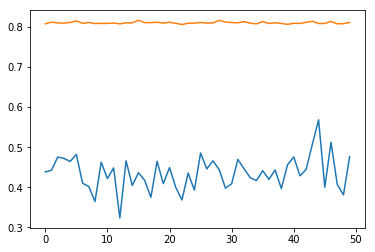

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

listConditional = []
listDualConditional = []
print(len(ORF_motifs))

for idx, sMotif in enumerate(ORF_motifs):
    print("Progress: {} / {}".format(idx, len(ORF_motifs)))
    conditional = check_correlation(tf_motifs, sMotif, listCRefSeq_Down)
    dual_conditional = check_correlation_absence(tf_motifs, sMotif, listCRefSeq_Not_Down)
    listConditional.append(conditional)
    listDualConditional.append(dual_conditional)

plt.plot(listConditional[:50])
plt.plot(listDualConditional[:50])
plt.show()